# Localización de objetos

En este tutorial veremos una forma sencilla de localizar un objeto en una imagen. Para eso, vamos a realizar dos asunciones sobre el objeto:
* Tiene un color relativamente uniforme en toda su superficie
* Es el único objeto con ese color en la imagen. 

En este caso, vamos a intentar encontrar la persona con remera verde:

TODO: poner la imagen con la persona localizada

![Imagen con objeto a reconocer](examples/info4.jpg "Imagen con objeto a reconocer")

Nuestro objetivo entonces es obtener las coordenadas $(x,y)$ del objeto en la imagen, encontrando su remera.

La idea principal del método es encontar los píxeles que tengan el color de la remera, remover el ruido, y luego encontrar el centro de la zona contigua que tiene ese color.

Comenzaremos cargando varias librerías que luego nos serán útiles. Luego cargaremos la imagen y viendo las distintas operaciones necesarias para encontrar el objeto.

In [13]:

# comando de Jupyter para que las imagenes se muestren automaticamente 
%matplotlib inline

#numpy es la libreria de arreglos de python (la llamaremos np)
import numpy as np
#el modulo io de skimage sirve para cargar y guardar imagenes
from skimage import io
# el modulo pyplot de matplotlib (que llamaremos plt) nos permite mostrar imagenes
import matplotlib.pyplot as plt
#el modulo matplotlib.colors nos permite transformar el espacio de color de una imagen
import matplotlib.colors


Luego, cargamos la imagen y la mostramos para verificar que se cargó correctamente.

Dimensiones de la imagen: (320, 560, 3)
Tipo de los elementos de la imagen: float64


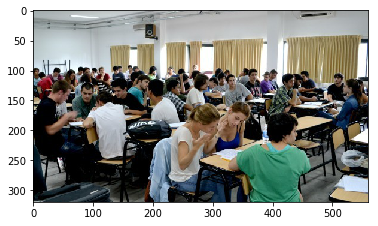

In [7]:

# leemos la imagen desde un archivo, y la almacenamos en memoria en un arreglo
image = io.imread('examples/info4.jpg')

# Convertimos la imagen de entero a flotante, y además convertimos el rango de los pixeles
# de 0-255 (entero) al rango 0-1 (flotante)
image=image/255.

#imprimimos las tres dimensiones del arreglo: las dos primeras corresponden al alto y ancho, 
#la última a los canales de color (3 canales, por defecto RGB)
print("Dimensiones de la imagen: %s" % str(image.shape))

#guardamos las dimensiones en tres variables para usar en los scripts más abajo
h,w,c=image.shape

#mostramos el tipo de los elementos del arreglo (debería ser flotante!)
print("Tipo de los elementos de la imagen: %s" % str(image.dtype))

#visualizamos la imagen
plt.imshow(image)


## Filtrado por color

Una manera simple de reconocer un objeto es mediante su color. Si ese color es muy distintivo y uniforme (las asunciones que mencionamos arriba), podemos recorrer la imagen para encontrar los pixeles de ese color.


Enfoquémosnos en la remera:

![Imagen con objeto a reconocer](examples/info4_zoom.jpg "Imagen con objeto a reconocer")

Como se puede ver no hay _un_ solo verde sino varios, por variaciones de la iluminación y la textura de la remera.

Entonces, en lugar de buscar _un_ color en particular, vamos a tener que buscar un rango de colores. Pero esto va a resultar difícil con el espacio de color RGB.


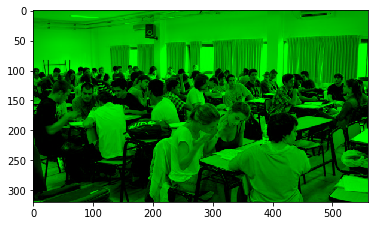

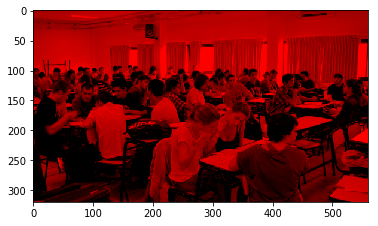

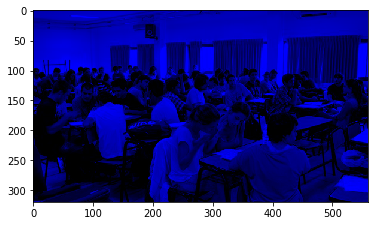

In [10]:
#Vemos los canales individuales de RGB. 
#Si bien la zona de la remera activa (se vé más claro) más que otras el canal verde,
#hay varias otras zonas que también lo activan.
# Por otro lado, la zona de la remera también se activa en los canales azul y rojo.

#Anulo los canales rojo y azul para ver solo el verde
green=np.copy(image)
green[:,:,0]=0
green[:,:,2]=0
plt.figure()
plt.imshow(green)

#Anulo los canales azul y verde para ver solo el rojo
red=np.copy(image)
red[:,:,1:3]=0
plt.figure()
plt.imshow(red)

#Anulo los canales rojo y verde para ver solo el azul
blue=np.copy(image)
blue[:,:,0:2]=0
plt.figure()
plt.imshow(blue)


## Conversión al espacio de colores HSV

En lugar de eso vamos a convertir los píxeles desde el espacio RGB al espacio HSV, en donde cada píxel se codifica también con tres valores, pero ahora con significado diferente:

 * El canal H indica el tono (hue) del color (verde, rojo, azul, amarillo, etc).
   * El tono es lo que tradicionalmente entendemos como "color".
 * El canal S indica la saturación (saturation) de color
   * Si un color es más saturado, es más "puro"
   * Si es menos saturado, tiene más "gris"
 * El canal V indica la luminosidad o intensidad (value) del pixel. 
   * V=0 indica un pixel negro
   * V=1 indica un pixel blanco
   
TODO poner ejemplos de colores HSV

La función `rgb_to_hsv` del módulo `matplotlib.colors`nos permite hacer justamente eso.   

In [15]:
# Convertir en escala de grises
image_hsv=matplotlib.colors.rgb_to_hsv(image)

print("El pixel de la posición (100,100) se codifica en RGB como %s " % str(image[100,100,:]))
print("El pixel de la posición (100,100) se codifica en HSV como %s " % str(image_hsv[100,100,:]))

El pixel de la posición (100,100) se codifica en RGB como [ 0.11372549  0.0627451   0.03137255] 
El pixel de la posición (100,100) se codifica en HSV como [ 0.06349206  0.72413793  0.11372549] 


## Filtrando el color


Para filtrar por color, debemos averiguar el rango de colores de la remera. Para ello, una forma sencilla consiste en abrir la imagen en un editor de imágenes que permita ver el valor de cada pixel, y anotar los valores de varios pixeles. En este caso lo hicimos y obtuvimos:
* $(H,S,V)$
* $(158,56,60)$
* $(160,70,48)$
* $(158,49,64)$
* $(158,49,64)$
* $(158,94,36)$
* $(161,78,43)$
* $(160,74,42)$


Entonces el rango de colores que buscamos es, aproximadamente:

 * H entre $158$ y $161$.
 * S entre $49$ y $94$.
 * V entre $42$ y $64$.
 

Como podemos observar, el canal H es el que mostró menos variación,ya que el tono se mantiene bastante constante. Por otro lado, el S y el V pueden variar mucho de acuerdo a la iluminación.

Por otro lado, los editores de imágenes nos dan estos valores codificados en los rangos 0-360 para H, y 0-100 para V y S, por lo que habría que convertirlos a los intervalos 0-1 que utiliza numpy dividiendo por el extremo del rango, es decir:

 * H entre $158/360$ y $161/360$.
 * S entre $49/100$ y $94/100$.
 * V entre $42/100$ y $64/100$.

In [16]:
#Rango de colores a utilizar

h_min,h_max=(158/360,161/360)
s_min,s_max=(49/100,94/100)
v_min,v_max=(42/100,64/100)



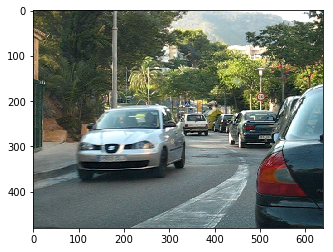

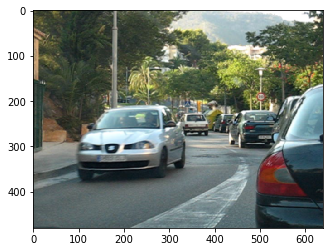

In [66]:
#suavizar una imagen -  en una funcion

import numba #usamos numba para que sea más rápido

@numba.jit #pre-compilamos la función a código de máquina para que sea más rápida
def smooth_image(image):    
    image_smooth=np.copy(image)

    for i in range(1,h-1):#evitamos los bordes
        for j in range(1,w-1): #evitamos los bordes
            image_smooth[i,j,:]= (image[i-1,j-1,:]+image[i-1,j,:]+image[i-1,j+1,:]
                                  +image[i,j-1,:]+image[i,j,:]+image[i,j+1,:]
                                  +image[i+1,j-1,:]+image[i+1,j,:]+image[i+1,j+1,:]
                                   )/9
    return image_smooth

image_smooth=smooth_image(image)

plt.imshow(image)
plt.figure()
plt.imshow(image_smooth)


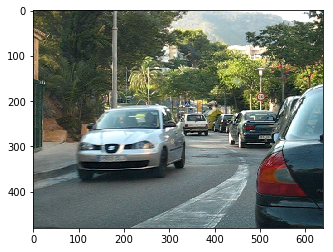

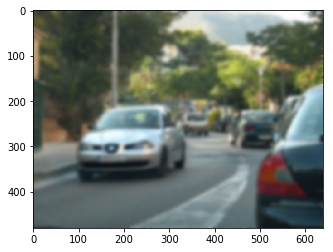

In [68]:
#suavizar una imagen varias veces

import numba #usamos numba para que sea más rápido

@numba.jit #pre-compilamos la función a código de máquina para que sea más rápida
def smooth_image(image):    
    image_smooth=np.copy(image)

    for i in range(1,h-1):#evitamos los bordes
        for j in range(1,w-1): #evitamos los bordes
            image_smooth[i,j,:]= (image[i-1,j-1,:]+image[i-1,j,:]+image[i-1,j+1,:]
                                  +image[i,j-1,:]+image[i,j,:]+image[i,j+1,:]
                                  +image[i+1,j-1,:]+image[i+1,j,:]+image[i+1,j+1,:]
                                   )/9
    return image_smooth


image_smooth=np.copy(image)
repetitions=20
for i in range(repetitions):
    image_smooth=smooth_image(image_smooth)

plt.imshow(image)
plt.figure()
plt.imshow(image_smooth)


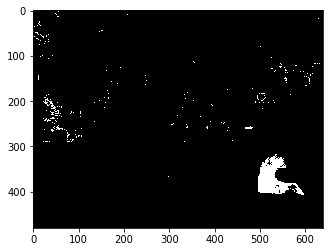

In [75]:
# Filtrar por color para buscar los rojos
h,w,c=image.shape
filter_mask=np.zeros((h,w))

for i in range(h):#evitamos los bordes
    for j in range(w): #evitamos los bordes
        r,g,b=image[i,j,:]
        if r>0.3 and g<0.3 and b<0.3:
            filter_mask[i,j]=1
            
plt.imshow(filter_mask,cmap=plt.get_cmap('gray'))            
        


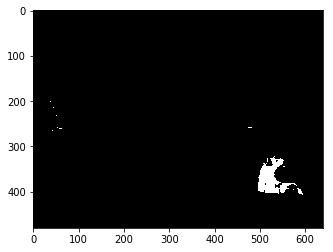

In [89]:
eroded_filter=np.zeros(filter_mask.shape)
# erosionar la mascara de filtro
for i in range(1,h-1):#evitamos los bordes
    for j in range(1,w-1): #evitamos los bordes
        pixel_count=(filter_mask[i-1,j-1]+filter_mask[i-1,j]+filter_mask[i-1,j+1] +filter_mask[i,j-1]+filter_mask[i,j]+filter_mask[i,j+1]+filter_mask[i+1,j-1]+filter_mask[i+1,j]+filter_mask[i+1,j+1])
        if pixel_count>8:
            eroded_filter[i,j]=1

plt.imshow(eroded_filter,cmap=plt.get_cmap('gray'))            


In [ ]:
import matplotlib.patches as patches

# Calcular centro de masa
eroded_filter=np.zeros(filter_mask.shape)
# erosionar la mascara de filtro
coordinate_sum=np.array([0,0])
count=0
for i in range(h):#evitamos los bordes
    for j in range(w): #evitamos los borde
        if eroded_filter[i,j]==1:
            coordinate_sum+=np.array([i,j])
            count+=1
center=coordinate_sum/count

figure()
plt.imshow(image,cmap=plt.get_cmap('gray'))
canvas = plt.gca()
rectangle=patches.Rectangle(
        (0.03, 0.1), 0.2, 0.6, fill=True)
canvas.add_patch()
